In [1]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import astropy
from astropy import units as u
import astromet
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
print(dir(astromet))

['AU', 'AU_c', 'Delta', 'G', 'Galt', 'Gyr', 'T', 'Time', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'abs_file_path', 'agis', 'agis_2d_prior', 'astropy', 'barycentricPosition', 'binaryMotion', 'bjd_to_bjyr', 'bjyr_to_bjd', 'bodyPos', 'c', 'day', 'design_matrix', 'downweight', 'dtheta_full', 'dtheta_simple', 'e', 'en_fit', 'findEtas', 'fit', 'fit_model', 'gaia_fit', 'get_gaiat', 'get_obmt', 'kpc', 'lSun', 'local_dir', 'mSun', 'mags', 'mas', 'mas2rad', 'mock_obs', 'np', 'os', 'params', 'period', 'rel_path', 'scipy', 'sigString', 'sigma_al_data', 'sigma_als', 'sigma_ast', 'sigmagamma', 'splitFit', 'splitInverse', 'splitNormal', 'sys', 'track', 'u', 'year']


In [5]:
dr2period=22/12 # in years
edr3Period=34/12 # in years
mas=astromet.mas # conversion from degrees to milli-arcseconds

In [6]:
# an object wich holds all the necessary parameters to find the astrometric path
params=astromet.params()

# For this example we'll generate a random binary system

# center of mass parameters
params.RA=360*np.random.rand()
params.Dec=90*(-1+2*np.random.rand())
print('RA and Dec [degrees]: \n',params.RA,params.Dec)
params.pmRAc=10*np.random.randn()
params.pmDec=10*np.random.randn()
print('Proper motion in RA and Dec [mas/yr]: \n',params.pmRAc,params.pmDec)
params.pllx=1+9*np.random.rand()
print('Parallax [mas]: \n',params.pllx)

# binary parameters
params.M=1000*np.random.rand()**2
print('Mass of brightest source [mSun]: \n',params.M)
params.a=100*np.random.rand()
print('Semi-major axis [AU]: \n',params.a)
params.e=np.random.rand()
print('Eccentricity [dimensionless]: \n',params.e)
params.q=10*(np.random.rand()**4)
params.l=np.random.rand()
print('Light (l<1) and mass (q) ratios of binary [dimensionless]: \n',params.l,params.q)
params.vPhi=2*np.pi*np.random.rand()
params.vTheta=np.pi*np.random.rand()
print('On-sky projection angles (vPhi and vTheta) of binary [radians]: \n',params.vPhi,params.vTheta)
params.vOmega=2*np.pi*np.random.rand()
print('On-sky orientation angle of binary [radians]: \n',params.vOmega)
params.tPeri=2016+astromet.period(params)*np.random.rand()
print('Time of first binary periapse [years]: \n',params.tPeri)

print('\nPeriod [years]: \n',astromet.period(params))

RA and Dec [degrees]: 
 205.27783629151045 -63.747952317719054
Proper motion in RA and Dec [mas/yr]: 
 -5.491953458805315 2.0058658668749767
Parallax [mas]: 
 4.003087093096657
Mass of brightest source [mSun]: 
 171.63386770745456
Semi-major axis [AU]: 
 52.384338285085555
Eccentricity [dimensionless]: 
 0.5104585242238863
Light (l<1) and mass (q) ratios of binary [dimensionless]: 
 0.5798767790479369 0.5790333796213839
On-sky projection angles (vPhi and vTheta) of binary [radians]: 
 0.8385092926347228 0.582365515830476
On-sky orientation angle of binary [radians]: 
 0.22829624288317715
Time of first binary periapse [years]: 
 2036.3497336967203

Period [years]: 
 23.035433262354683


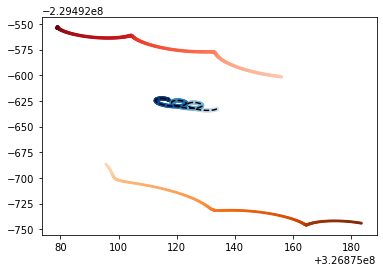

In [7]:
# calculating the on-sky path
plotts=np.linspace(2016-0.5*edr3Period,2016+0.5*edr3Period,256)

# first just the c.o.m. 
raccoms,deccoms=astromet.track(plotts,params,comOnly=True)
# then the positions of the centre of light, and both masses
raccols,deccols,rac1s,dec1s,rac2s,dec2s=astromet.track(plotts,params,allComponents=True)

# colouring by time (white to coloured)
ccols=mpl.cm.Blues(np.interp(plotts,[plotts[0],plotts[-1]],[0.2,1]))
c1s=mpl.cm.Reds(np.interp(plotts,[plotts[0],plotts[-1]],[0.2,1]))
c2s=mpl.cm.Oranges(np.interp(plotts,[plotts[0],plotts[-1]],[0.2,1]))

ss=np.ones_like(plotts)

# plotting
trackPlot=plt.gca()
trackPlot.plot(raccoms,deccoms,c='k',ls='--')
trackPlot.scatter(raccols,deccols,c=ccols,s=10)
trackPlot.scatter(rac1s,dec1s,c=c1s,s=10/(1+params.l))
trackPlot.scatter(rac2s,dec2s,c=c2s,s=10*params.l/(1+params.l))
plt.show()

0.3304034034155648
0.7835099431207907
1.8579948772411023
4.406000197143605
10.448273014646414
24.77675989650674
58.75495693006828
139.32995994124695
330.4034034155648


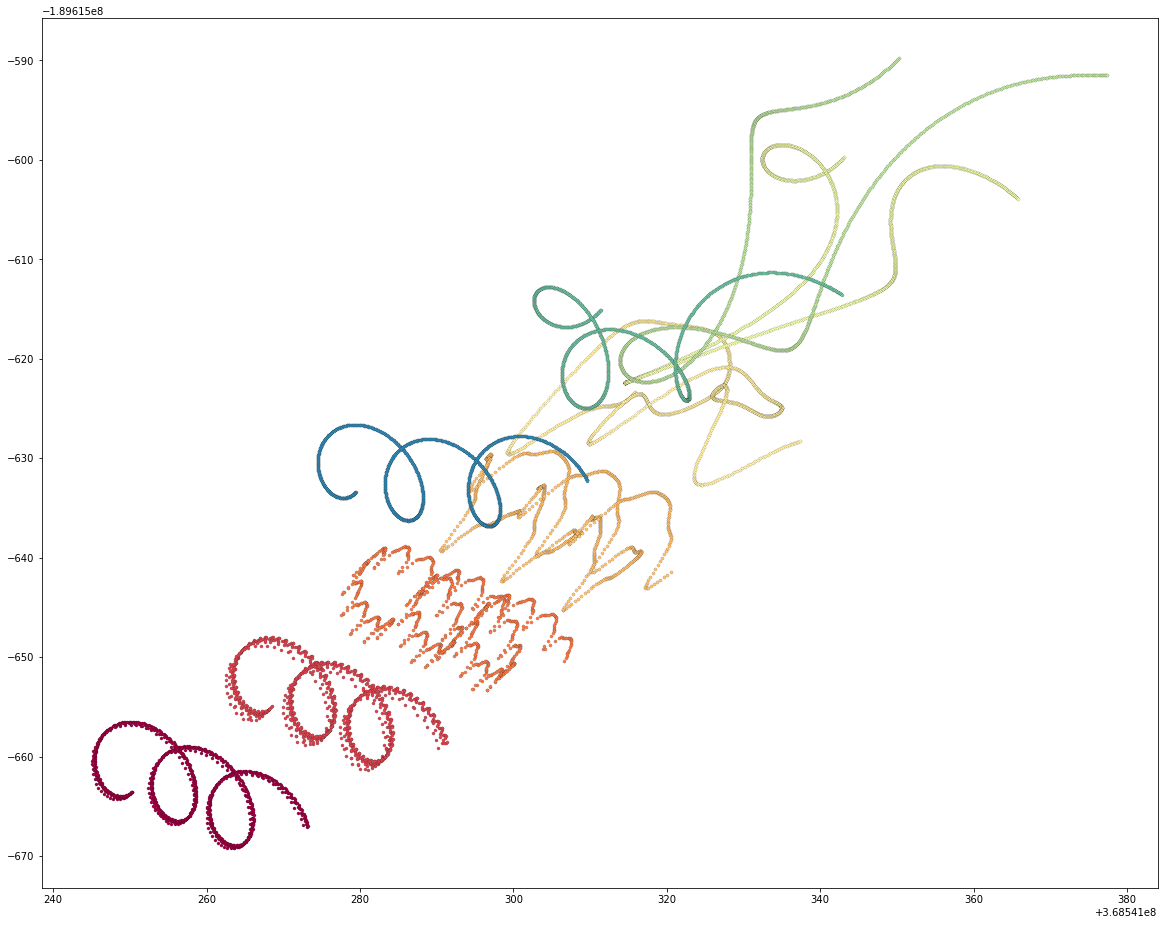

In [19]:
ra=168.822791746732
dec=-52.67101756954034

pmra=7.475988873971572
pmdec=-2.479795383222872
pllx=4.9486674220605735
M=818.576627957461
a=10.448273014646414
e=0.8343208178025897
l=0.2468491575204601
q=2.0907266576304272e-05
vPhi=4.51073351780632
vTheta=1.551335064467769
vOmega=5.608334008004396
t0=2016.0984934731916

ntrack=9
alist=a*10**np.linspace(-1.5,1.5,ntrack)

plotts=np.linspace(2016-0.5*edr3Period,2016+0.5*edr3Period,1000)
qFig=plt.figure(figsize=(20,16))
qPl=plt.gca()

for i in range(ntrack):
    params=astromet.params()

    params.RA=ra-2*(i**2)*astromet.mas
    params.Dec=dec+8*i*astromet.mas
    params.pmRAc=pmra
    params.pmDec=pmdec
    params.pllx=pllx
    params.M=M
    params.a=alist[i]
    print(params.a)
    params.e=e
    params.q=q
    params.l=l
    params.vPhi=vPhi
    params.vTheta=vTheta
    params.vOmega=vOmega
    params.tPeri=t0
    
    raccols,deccols=astromet.track(plotts,params)
    c=mpl.cm.Spectral(i/ntrack)
    qPl.scatter(raccols,deccols,color=c,s=10,zorder=2,edgecolor='k',lw=0.1)
    #qPl.scatter(raccols,deccols,color='k',s=16,zorder=1)
    
#plt.savefig('astrometricTracksExample.pdf')
plt.show()

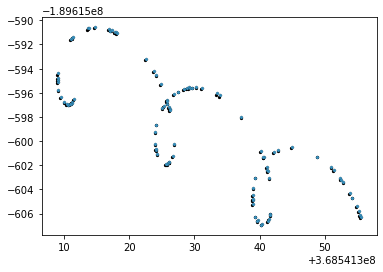

In [17]:
ts=2016+np.sort(edr3Period*(-0.5+np.random.rand(100)))
qPl=plt.gca()
params.pmRAc=2*pmra
params.pmDec=2*pmdec
params.a=alist[4]
raccoms,deccoms=astromet.track(ts,params,comOnly=True)
raccols,deccols=astromet.track(ts,params)

phis=360*np.random.rand(ts.size)

talls=np.hstack([ts,ts])
phialls=np.hstack([phis,phis+90])
racalls=np.hstack([raccols,raccols])
decalls=np.hstack([deccols,deccols])
erralls=np.hstack([0.1*np.ones(ts.size),0.3*np.ones(ts.size)])

xs=astromet.mock_obs(phialls,racalls,decalls,err=erralls)

results=astromet.gaia_fit(talls,xs,phialls,erralls,params.RA,params.Dec)


c=mpl.cm.Spectral(i/ntrack)
qPl.scatter(raccoms,deccoms,color='k',s=5,zorder=2)
qPl.scatter(raccols,deccols,color=c,s=10,zorder=2,edgecolor='k',lw=0.1)
plt.show()

In [18]:
print(results)

{'astrometric_matched_transits': 200, 'visibility_periods_used': 65, 'astrometric_n_obs_al': 1800, 'astrometric_params_solved': 31, 'ra': 168.82275612985043, 'ra_error': 1.3490688198186976e-09, 'dec': -52.67099976765594, 'dec_error': 1.1781683784902416e-09, 'ra_dec_corr': -0.023855194647647442, 'parallax': 4.963634353713132, 'parallax_error': 0.0052187730520326225, 'ra_parallax_corr': -0.06220030692106297, 'dec_parallax_corr': -0.006141026314872966, 'pmra': 14.930810118850786, 'pmra_error': 0.005952871547201723, 'ra_pmra_corr': 0.05113269873979824, 'dec_pmra_corr': -0.015784429167776837, 'parallax_pmra_corr': -0.1613572159347737, 'pmdec': -4.953657186590135, 'pmdec_error': 0.004990358528653728, 'ra_pmdec_corr': -0.014336865543146072, 'dec_pmdec_corr': 0.008779605266794291, 'parallax_pmdec_corr': -0.059029989607963705, 'pmra_pmdec_corr': -0.06030332694568167, 'astrometric_excess_noise': 0.0, 'astrometric_chi2_al': 1910.7882824362036, 'astrometric_n_good_obs_al': 1800, 'UWE': 1.031749003

In [86]:
# simulating observables

# times when system is observed [years, CE]
ts=2016+np.sort(edr3Period*(-0.5+np.random.rand(64)))

raccols,deccols=astromet.track(ts,params)

phis=360*np.random.rand(ts.size)

talls=np.hstack([ts,ts])
phialls=np.hstack([phis,phis-90])
racalls=np.hstack([raccols,raccols])
decalls=np.hstack([deccols,deccols])
erralls=np.hstack([0.3*np.ones(ts.size),np.ones(ts.size)])

xs=astromet.mock_obs(phialls,racalls,decalls,err=erralls)

results=astromet.gaia_fit(talls,xs,phialls,erralls,params.RA,params.Dec)

'''scanPlot=plt.gca()
for i in range(xs.size):
    xvals=[(xs[i]-erralls[i])*np.sin(phialls[i]),(xs[i]+erralls[i])*np.sin(phialls[i])]
    yvals=[(xs[i]-erralls[i])*np.cos(phialls[i]),(xs[i]+erralls[i])*np.cos(phialls[i])]
    scanPlot.plot(xvals,yvals)
plt.show()'''

'scanPlot=plt.gca()\nfor i in range(xs.size):\n    xvals=[(xs[i]-erralls[i])*np.sin(phialls[i]),(xs[i]+erralls[i])*np.sin(phialls[i])]\n    yvals=[(xs[i]-erralls[i])*np.cos(phialls[i]),(xs[i]+erralls[i])*np.cos(phialls[i])]\n    scanPlot.plot(xvals,yvals)\nplt.show()'

In [87]:
print(params.RA)
print(params.Dec)
print(params.pmRAc)
print(params.pmDec)
print(params.pllx)
print(results)

168.82275619117647
-52.67099979176256
14.951977747943143
-4.959590766445744
4.9486674220605735
{'astrometric_matched_transits': 128, 'visibility_periods_used': 49, 'astrometric_n_obs_al': 1152, 'astrometric_params_solved': 31, 'ra': 168.82275214002843, 'ra_error': 2.2153284570453586e-08, 'dec': -52.67099750992917, 'dec_error': 2.2032767772902574e-08, 'ra_dec_corr': 0.03326012162060472, 'parallax': 5.209579989750637, 'parallax_error': 0.08846622555510493, 'ra_parallax_corr': -0.024157440979990157, 'dec_parallax_corr': 0.010134788525632765, 'pmra': 14.881687678829621, 'pmra_error': 0.10717485515778022, 'ra_pmra_corr': -0.005290684179428622, 'dec_pmra_corr': 0.023611493068272444, 'parallax_pmra_corr': 0.041077590468054606, 'pmdec': -4.891023211879656, 'pmdec_error': 0.10741579371584382, 'ra_pmdec_corr': 0.02686410703933926, 'dec_pmdec_corr': 0.04413405540777682, 'parallax_pmdec_corr': -0.18020694839706858, 'pmra_pmdec_corr': 0.02836217173780305, 'astrometric_excess_noise': 2.9908008259089

In [106]:
xerrs=0.5*np.random.randn(phis.size)*np.sin(phis)+1.5*np.random.randn(phis.size)*np.cos(phis)
yerrs=0.5*np.random.randn(phis.size)*np.cos(phis)-1.5*np.random.randn(phis.size)*np.sin(phis)

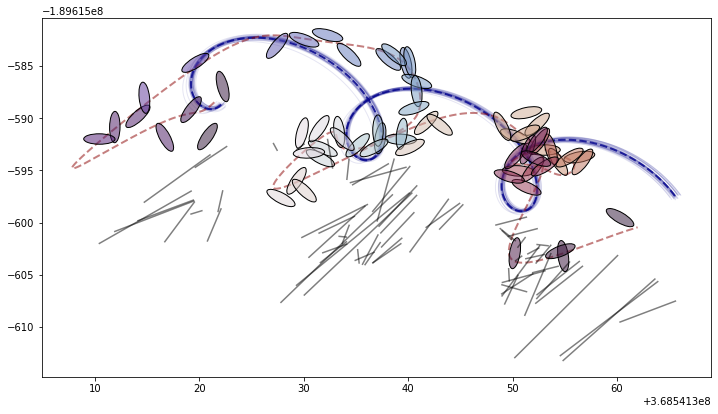

In [113]:
# plotting on sky motion
qFig=plt.figure(figsize=(12,8))
qPl=plt.gca() # defining matplotlib axis object on which to plot
qPl.set_aspect('equal')

cs=mpl.cm.twilight_shifted(np.interp(ts,[ts[0],ts[-1]],[0,1])) # optional, but I like to color by time
cs[:,3]=0.5

# plotting the datapoints (ideally as error ellipses -
# if that fails comment out the for loop and use the simpler scatter plot instead)
astError=0.3
for i in range(raccols.size):
    xval=raccols[i]+xerrs[i]
    yval=deccols[i]+yerrs[i]
    ell = mpl.patches.Ellipse(xy=(xval,yval),
                  width=1, height=3,
                  angle=phis[i])
    ell.set_facecolor(cs[i])
    ell.set_edgecolor('k')
    qPl.add_artist(ell)

# uniformly sampled times for plotting true paths
tUniform=np.linspace(ts[0],ts[-1],1000)

# optional - adding the centre of mass motion (black) for reference
comRas,comDecs=astromet.track(tUniform,params,comOnly=True)
qPl.plot(comRas,comDecs,lw=1,c='k',alpha=0.0,zorder=1)

# optional - adding the centre of mass motion (red) for reference
trueRas,trueDecs=astromet.track(tUniform,params)
qPl.plot(trueRas,trueDecs,lw=2,c='darkred',alpha=0.5,zorder=1,ls='--')

# optional - adding fitted motion (blue)
for i in range(32):
    randRa=results['ra']+results['ra_error']*np.random.randn()
    randDec=results['dec']+results['dec_error']*np.random.randn()
    randPmRa=results['pmra']+results['pmra_error']*np.random.randn()
    randPmDec=results['pmdec']+results['pmdec_error']*np.random.randn()
    randPllx=results['parallax']+results['parallax_error']*np.random.randn()
    
    fitPs=astromet.params()
    fitPs.RA=randRa
    fitPs.Dec=randDec
    fitPs.pmRAc=randPmRa
    fitPs.pmDec=randPmDec
    fitPs.pllx=randPllx
    bestRas,bestDecs=astromet.track(tUniform,fitPs,comOnly=True)
    qPl.plot(bestRas,bestDecs,lw=1,c='darkblue',alpha=0.1,zorder=0)
fitPs=astromet.params()
fitPs.RA=results['ra']
fitPs.Dec=results['dec']
fitPs.pmRAc=results['pmra']
fitPs.pmDec=results['pmdec']
fitPs.pllx=results['parallax']
bestRas,bestDecs=astromet.track(tUniform,fitPs,comOnly=True)
qPl.plot(bestRas,bestDecs,lw=2,c='darkblue',alpha=0.8,zorder=0,ls='--')

bestRa2s,bestDec2s=astromet.track(ts,fitPs,comOnly=True)
for i in range(raccols.size):
    xval=raccols[i]+xerrs[i]
    yval=deccols[i]+yerrs[i]
    qPl.plot([xval,bestRa2s[i]],[yval,bestDec2s[i]],c='k',alpha=0.5)
# adding initial position and proper motion as arrow
#qPl.arrow(np.median(ras*np.cos(decs*np.pi/180)),np.median(decs),mas*params.pmRA,mas*params.pmDec,color='k',alpha=0.5)


plt.show()

In [53]:
print('Period: ',astromet.period(params))
print('eccentricity: ',params.e)
uweobs=astromet.uwe(ts,ras,decs,fitParams,astError=1)
print('____________UWE obs: ',uweobs)
dthetapred=astromet.dThetaEstimate(params,ts[0],ts[-1])
print('____________UWE predicted: ',np.sqrt(1+(dthetapred)**2))
dthetasimp=astromet.dThetaEstimate(params,ts[0],ts[0]+params.P)
print('____________UWE simple: ',np.sqrt(1+(dthetasimp)**2))

Period:  1.1806574173832154
eccentricity:  0.8343208178025897


AttributeError: module 'astromet' has no attribute 'uwe'